# EMNLP IU-Boundary Code
This notebook is defines a class to produce the raw counts, metrics, and language distribution graphs for a given transcript. Refer to the README file for our assumptions about the Excel format.

In [1]:
# mount google drive
from google.colab import drive
import os

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Class Definition

In [2]:
class IUBoundaryMetrics:
  def __init__(self, data, n_languages=2, lang_tag_col_name="Clean Lang Tag", speaker_col_name="Speaker Type"):
    self.df = data
    self.langtag_col_name = lang_tag_col_name
    self.speaker_col = speaker_col_name
    self.n_languages = n_languages
    self.IU_lang_visualizations = []
    # dictionary for the Ls counted
    self.raw_counts_L = {
        "total_valid_rows": 0,    # rows counted after filtering for desired language tags
        "n_speaker_rows"  : 0,    # IU rows that are speaker
        "n_interviewer_rows": 0,  # IU rows that are interviewer
        "across-switch"   : 0,    # how many times is there a boundary switch?
        "L_count"         : [],   # how many IUs have Ls? (and how many?)
        "within-switch"   : [],   # how many switches happen within the IU?
        "IU_lang_rows"    : [],   # language tag measurements after filtering out non- S/E/L
    }
    # dictionary for no Ls counted
    self.raw_counts_no_L = {
        "total_valid_rows": 0,    # rows counted after filtering for desired language tags
        "n_speaker_rows"  : 0,    # IU rows that are speaker
        "n_interviewer_rows": 0,  # IU rows that are interviewer
        "across-switch"   : 0,    # how many times is there a boundary switch?
        "L_count"         : [],   # how many IUs have Ls? (and how many?)
        "within-switch"   : [],   # how many switches happen within the IU?
        "IU_lang_rows"    : [],   # language tag measurements after filtering out non- S/E/L
    }
    self.M_index, self.across_I_index, self.within_I_index = 0.0, 0.0, 0.0

  def process_raw_info(self, include_L=False):
    prev_letter = ""
    raw_counts = {
        "total_valid_rows": 0,    # rows counted after filtering for desired language tags
        "n_speaker_rows"  : 0,    # IU rows that are speaker
        "n_interviewer_rows": 0,  # IU rows that are interviewer
        "across-switch"   : 0,    # how many times is there a boundary switch?
        "L_count"         : [],   # how many IUs have Ls? (and how many?)
        "within-switch"   : [],   # how many switches happen within the IU?
        "IU_lang_rows"    : [],   # language tag measurements after filtering out non- S/E/L
    }

    # loop through every IU row in the transcript
    for i in range(len(self.df[self.langtag_col_name])):

      # we want to filter out anything that isn't L or S or E (depending on our 'include_L' flag)
      curr_tag = df[self.langtag_col_name][i]
      if include_L:
        curr_tag = [x for x in curr_tag if x in ["L", "S", "E"]]
      else:
        curr_tag = [x for x in curr_tag if x in ["S", "E"]]
      # the metrics in this if statement is meant for sanity checking and ensuring majority monological transcripts
      if (len(curr_tag) > 0):
        raw_counts["total_valid_rows"] += 1
        if (self.df[self.speaker_col][i] == "Participant"):     # TODO: change the name of the column if necessary
          raw_counts["n_speaker_rows"] += 1
        elif (self.df[self.speaker_col][i] == "Interviewer"):   # TODO: change the name of the column if necessary
          raw_counts["n_interviewer_rows"] += 1

      # count the Ls in the current IU row
      if include_L:
        L_count = curr_tag.count("L")
        raw_counts["L_count"].append(L_count)

      # process every tag in the IU
      curr_within_switch = 0
      for lang_idx, lang in enumerate(curr_tag):
        if (lang_idx == 0):
          # for the IU token level, remember that we only consider the first tag for each IU (for M-Index)
          raw_counts["IU_lang_rows"].append(lang)
        # this will only happen once for each for loop / IU row;
        # the last check makes sure we don't count the first row as an across IU switch
        if (lang_idx == 0) and (lang != prev_letter) and (prev_letter != ""):  # looking for across IU switching
          raw_counts["across-switch"] += 1
        elif (lang_idx > 0) and (lang != prev_letter): # looking for within IU switching
          curr_within_switch += 1
        prev_letter = lang
      raw_counts["within-switch"].append(curr_within_switch)

    if include_L:
      self.raw_counts_L = raw_counts
    else:
      self.raw_counts_no_L = raw_counts
    return raw_counts

  # This doesn't include counting the Ls
  def m_index(self):
    p = {
        "E": 0,
        "S":0
    }

    total_rows = 0
    for curr_lang_tag in self.raw_counts_no_L["IU_lang_rows"]:
      if curr_lang_tag == "E":
        p["E"] += 1
      elif curr_lang_tag == "S":
        p["S"] += 1
      total_rows += 1

    assert(p["S"] + p["E"] == total_rows) # sanity check

    for curr_p, count in p.items():
      p[curr_p] /= total_rows
      p[curr_p] = p[curr_p] ** 2

    p_sum = p["E"] + p["S"]
    self.M_index = (1 - p_sum) / ((self.n_languages - 1) * p_sum)

    return self.M_index

  # this function assumes the dataframe has already been processed in the ways desired (L or no L)
  def i_index_calculations(self, dataframe):
    # across IU only
    self.across_I_index = dataframe["across-switch"] / (dataframe["total_valid_rows"] - 1)

    # within IU only
    switch_count = len([x for x in dataframe["within-switch"] if x > 0])
    self.within_I_index = switch_count / (dataframe["total_valid_rows"])

    return self.across_I_index, self.within_I_index

  def visualize_transcript(self):
    lang_distributions = []
    for lang_tag in self.raw_counts_no_L["IU_lang_rows"]:
      if lang_tag == "E":
        lang_distributions.append(0)
      elif lang_tag == "S":
        lang_distributions.append(1)
    lang_distributions = np.asarray(lang_distributions).reshape(1, len(list(lang_distributions)), order="F")
    fig, ax = plt.subplots()
    ax.pcolormesh(lang_distributions)
    ax.set_frame_on(False)
    return

### Example w/ a Transcript

In [3]:
# load the excel data
import pandas as pd
import matplotlib.colors as mc # For the legend
import matplotlib.pyplot as plt
import numpy as np

# TODO: change this path to your data path
filepath = "/content/drive/MyDrive/Code-Switching-Work/updated-data/FILL_THIS_IN.xlsx"
df = pd.read_excel(filepath)

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [4]:
metrics = IUBoundaryMetrics(df)

In [5]:
no_L_raw_counts = metrics.process_raw_info(include_L = False)
L_raw_counts    = metrics.process_raw_info(include_L = True)

#### Print the Raw Counts Information
Related to information found in Table 1 of the paper.

In [6]:
# NOTE: We are exclusively looking for IUs with single language tags so as to not double count
print("Total eligible IUs: " + str(metrics.raw_counts_L["total_valid_rows"]))

E_count = len([x for x in metrics.raw_counts_L["IU_lang_rows"] if x == "E"])
S_count = len([x for x in metrics.raw_counts_L["IU_lang_rows"] if x == "S"])
L_count = len([x for x in metrics.raw_counts_L["IU_lang_rows"] if x == "L"])
mult_count = len([x for x in metrics.raw_counts_L["IU_lang_rows"] if len(x) > 1])
print("Total IUs counted as Es in transcript: " + str(E_count))
print("Total IUs counted as Ss in transcript: " + str(S_count))
print("Total IUs counted as Ls in transcript: " + str(L_count))
print("Total IUs with multiple language tags: " + str(mult_count))

# sanity check
assert(E_count + S_count + L_count + mult_count == metrics.raw_counts_L["total_valid_rows"])

print("Number of switches across IUs (no Ls): " + str(metrics.raw_counts_no_L["across-switch"]))
print("Number of switches across IUs (Ls incl.): " + str(metrics.raw_counts_L["across-switch"]))

print("Within IU switches (no Ls): " + str(len([x for x in metrics.raw_counts_no_L["within-switch"] if x > 0])))
print("Within IU switches (Ls incl.): " + str(len([x for x in metrics.raw_counts_L["within-switch"] if x > 0])))

print("Number of IUs that contain Ls: " + str(len([x for x in metrics.raw_counts_L["L_count"] if x > 0])))

Total eligible IUs: 1641
Total IUs counted as Es in transcript: 894
Total IUs counted as Ss in transcript: 737
Total IUs counted as Ls in transcript: 10
Total IUs with multiple language tags: 0
Number of switches across IUs (no Ls): 264
Number of switches across IUs (Ls incl.): 276
Within IU switches (no Ls): 21
Within IU switches (Ls incl.): 49
Number of IUs that contain Ls: 31


#### Print the Code-Switching Metrics
Related to Table 3 of the EMNLP paper.

In [7]:
print("M-Index: " + str(round(metrics.m_index(), 2)))

M-Index: 0.98


In [8]:
across_noL, within_noL = metrics.i_index_calculations(no_L_raw_counts)
print("Across IU I-Index with no Ls: " + str(round(across_noL, 2)))
print("Within IU I-Index with no Ls: " + str(round(within_noL, 2)))

Across IU I-Index with no Ls: 0.16
Within IU I-Index with no Ls: 0.01


In [9]:
across_L, within_L = metrics.i_index_calculations(L_raw_counts)
print("Across IU I-Index with Ls: " + str(round(across_L, 2)))
print("Within IU I-Index with Ls: " + str(round(within_L, 2)))

Across IU I-Index with Ls: 0.17
Within IU I-Index with Ls: 0.03


#### Print the Language Distribution Graph
Related to Figure 4 in EMNLP paper.

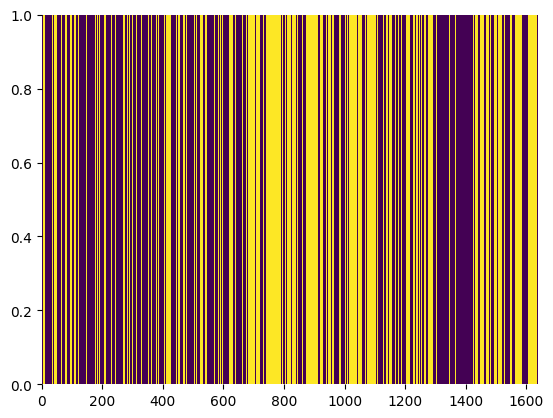

In [10]:
metrics.visualize_transcript()